In [37]:
pip install numba

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [38]:
from env import Enviroment
from evolved_agent import EvolvedAgent
from actors import Agent, Wall, Landmark
from typing import List
import numpy as np
from copy import deepcopy
from math import degrees, atan2, pi
from utils import distance_from_wall, intersection, angle_from_vector
import torch
from nn import NN
from parameters import *
import matplotlib.pyplot as plt

class EnvEvolution(Enviroment):
    def __init__(
        self,
        agent: EvolvedAgent,
        walls: List[Wall] = [],
        landmarks: List[Landmark] = [],
        height=800,
        width=800,
        instants=1000,
        w1=1,
        w2=1,
        w3=0.2,
    ):
        super().__init__(agent, walls, landmarks)
        self.height = height
        self.width = width
        self.map = np.zeros((self.width, self.height))
        self.collisions = 0
        self.movements = 0
        self.instants = instants
        self.W1 = w1
        self.W2 = w2
        self.W3 = w3
        self.distance = self.agent.max_distance * np.ones(self.instants)
        self.path = []

    def reset(self, random=False):
        if random:
            self.agent.pos = np.array(
                [np.random.randint(0, self.width), np.random.randint(0, self.height)],
                dtype=np.float64,
            )
            self.agent.direction_vector = np.array(
                [np.random.randint(-1, 2), np.random.randint(-1, 2)], dtype=np.float64
            )
        else:
            self.agent.pos = np.array([self.width // 2, self.height // 2], dtype=np.float64)
        self.collisions = 0
        self.movements = 0
        self.map = np.zeros((self.width, self.height))
        self.distance = self.agent.max_distance * np.ones(self.instants)
        self.path = []

    def move_agent(self, dt=1):
        try:
            sensor_data = self.get_sensor_data(
                self.agent.n_sensors, self.agent.max_distance
            )
            distances = np.array([data[1][0] for data in sensor_data], dtype=np.float32)
            if np.any(distances == self.agent.size):
                self.collisions += 1
            vl, vr = self.agent.controller.forward(torch.tensor(distances, dtype=torch.float))
            vl, vr = vl * 100, vr * 100
        except Exception as e:
            print(e)
            vl, vr = 0, 0
        v = (vl + vr) / 2
        w = (vr - vl) / (self.agent.size * 2)
        dtheta = w * dt

        if w == 0:
            dx = round(v * dt * np.cos(self.agent.direction))
            dy = round(v * dt * np.sin(self.agent.direction))
        else:
            R = v / w
            dx = round(R * (np.sin(self.agent.direction + dtheta) - np.sin(self.agent.direction)))
            dy = -(round(R * (np.cos(self.agent.direction + dtheta) - np.cos(self.agent.direction))))

        move_vector = np.array([dx, dy], dtype=np.float64) 
        print(f"Move vector: {move_vector}")

        for wall in self.walls:
            current_d = distance_from_wall(wall, self.agent.pos)
            if current_d <= self.agent.size:
                wall_vector = np.array([wall.end[0] - wall.start[0], wall.end[1] - wall.start[1]])
                wall_vector = wall_vector / np.linalg.norm(wall_vector)
                parallel_component = np.dot(wall_vector, move_vector) * wall_vector
                
                wall_to_agent = self.agent.pos - np.array(
                    distance_from_wall(wall, self.agent.pos, coords=True)
                )
                wall_to_agent = wall_to_agent / np.linalg.norm(wall_to_agent)
                self.agent.apply_vector(wall_to_agent * (self.agent.size - current_d))
                if np.dot(self.agent.direction_vector, -wall_to_agent) > 0:
                    move_vector = parallel_component

        # Check if the agent is making an illegal move
        for wall in self.walls:
            intersection_point = intersection(
                Wall(
                    self.agent.pos[0],
                    self.agent.pos[1],
                    self.agent.pos[0] + move_vector[0],
                    self.agent.pos[1] + move_vector[1],
                ),
                wall,
            )
            if intersection_point:
                return

        self.agent.apply_vector(move_vector)
        self.agent.rotate(dtheta)
        self.movements += 1
        x, y = round(self.agent.pos[0]), round(self.agent.pos[1])

        # Define the ranges ensuring they are within the bounds of the map
        x_start, x_end = max(0, x - 10), min(self.map.shape[0], x + 11)
        y_start, y_end = max(0, y - 10), min(self.map.shape[1], y + 11)

        # Set the specified region to 1
        self.map[x_start:x_end, y_start:y_end] = 1
        self.path.append((x, y))

    def fitness_score(self) -> float:
        return (
                self.explored_terrain
            + np.mean(1 / self.distance)
            +  np.exp(-self.collisions)
        )

    @property
    def explored_terrain(self) -> float:
        return np.sum(self.map) / (self.width * self.height)

    def visualize_movement(self):
        plt.figure(figsize=(10, 10))
        plt.imshow(self.map.T, origin='lower', cmap='gray_r')
        plt.colorbar(label='Explored')
        plt.scatter(self.agent.pos[0], self.agent.pos[1], color='red', s=self.agent.size*2, label='Agent')
        for wall in self.walls:
            plt.plot([wall.start[0], wall.end[0]], [wall.start[1], wall.end[1]], 'b-', linewidth=2)
        plt.plot([x[0] for x in self.path], [x[1] for x in self.path], 'r-', label='Path')
        plt.title('Agent Movement and Explored Terrain')
        plt.xlabel('Width')
        plt.ylabel('Height')
        plt.legend()
        plt.show()


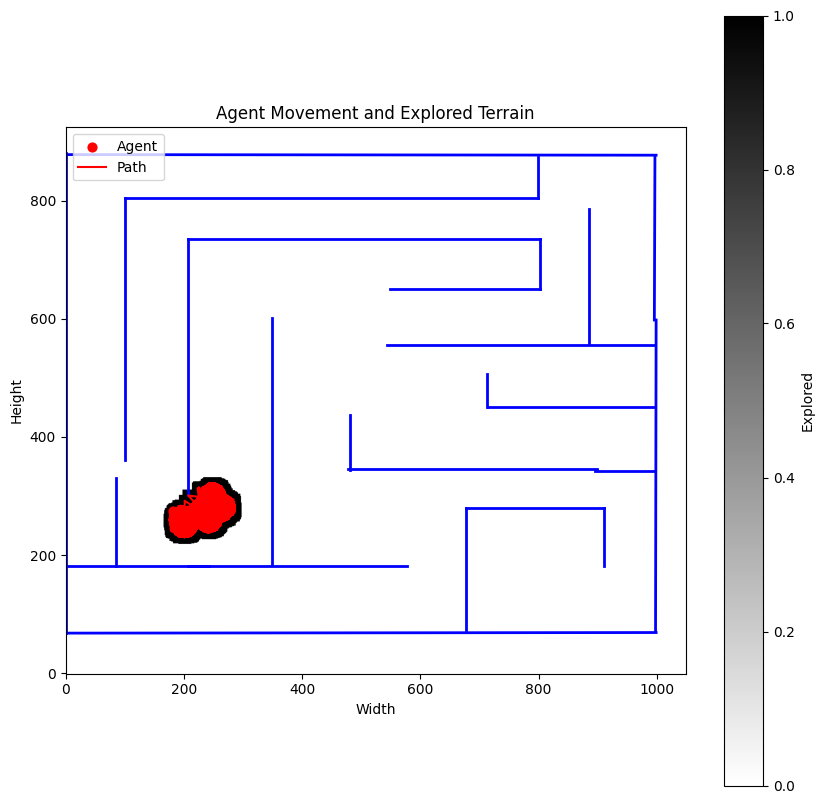

final pos [182. 275.]
collisions 0
explored terrain 0.01738125
fitness 1.02238125


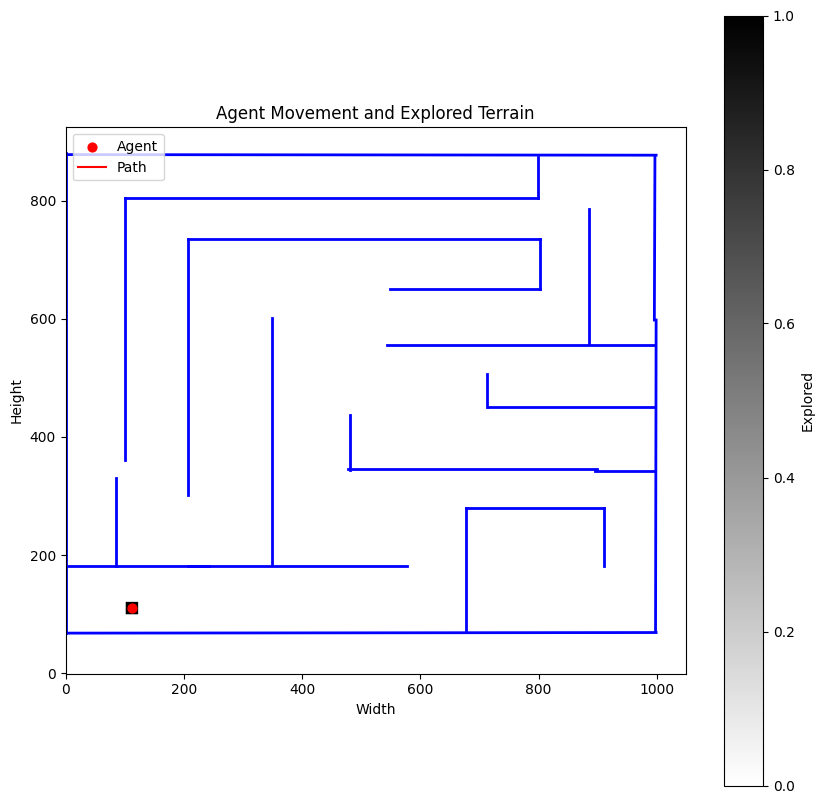

final pos [111. 111.]
collisions 0
explored terrain 0.0006890625
fitness 1.0056890625


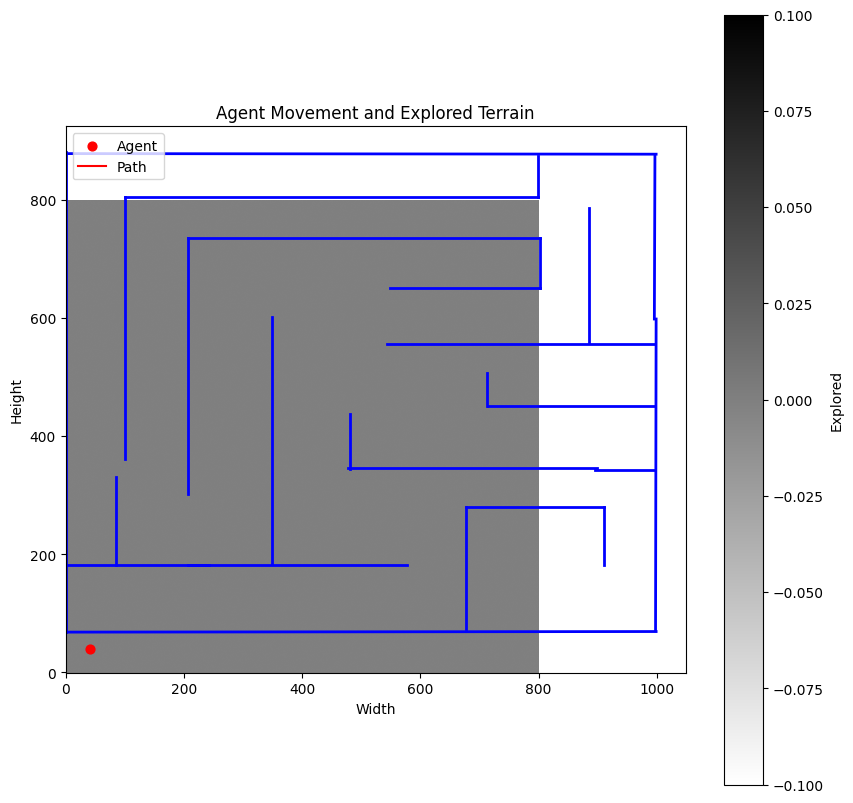

final pos [40. 40.]
collisions 0
explored terrain 0.0
fitness 1.005


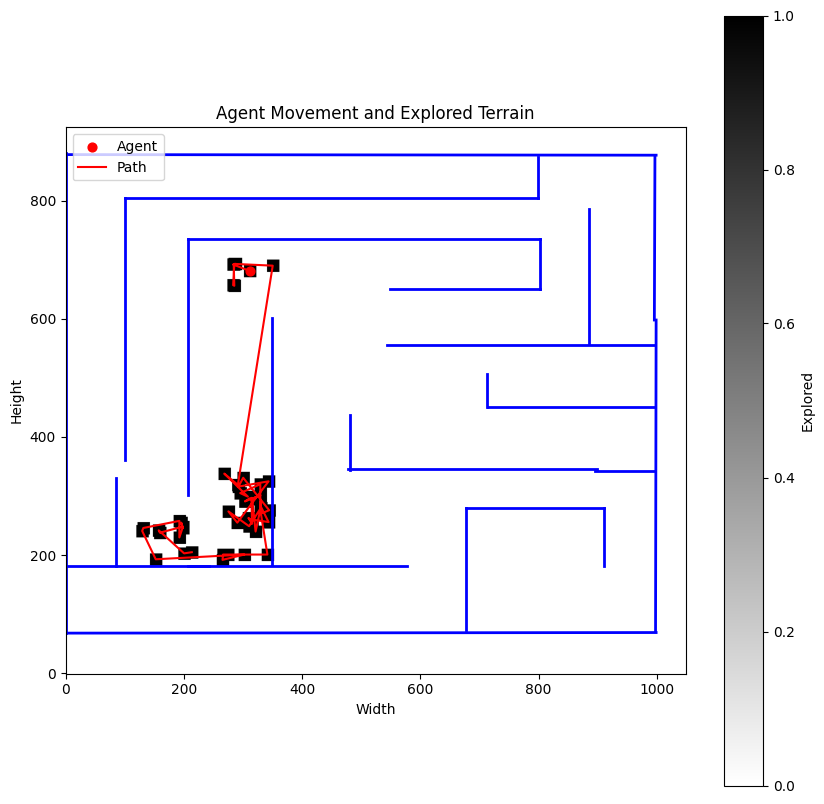

final pos [311. 681.]
collisions 0
explored terrain 0.0212890625
fitness 1.0262890625


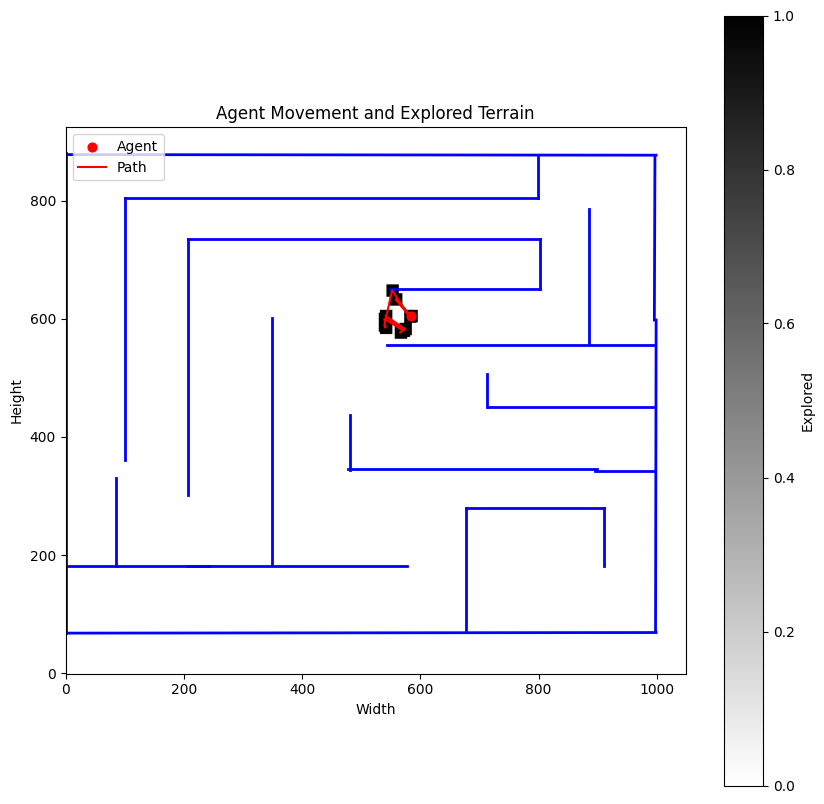

final pos [584. 605.]
collisions 0
explored terrain 0.004578125
fitness 1.009578125


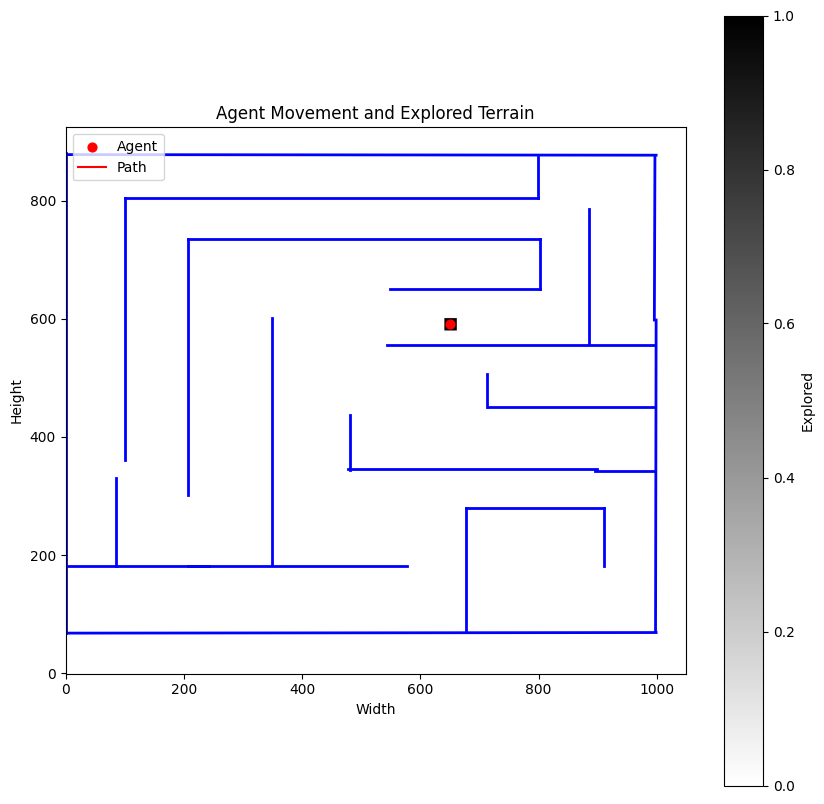

final pos [650. 591.]
collisions 0
explored terrain 0.0006890625
fitness 1.0056890625


KeyboardInterrupt: 

In [39]:
for simulation in range(10):    
    x,y = float(np.random.randint(10, 790)), float(np.random.randint(10, 790))
    env = EnvEvolution(
        EvolvedAgent(x=x, y=x, controller=NN(), n_sensors=12, max_distance=200,size=20),
        instants=10000,
        w1=1,
        w2=1,
        w3=0.2,
    )
    env.load_walls(WALLS_TXT)
    for step in range(5000):
        env.move_agent()
    
    env.visualize_movement()
    print("final pos", env.agent.pos)
    fitness = env.fitness_score()
    print("collisions", env.collisions)
    print("explored terrain", env.explored_terrain)
    print("fitness", fitness)
 
    